In [3]:
import numpy as np
from scipy.optimize import minimize
from consav.linear_interp import interp_1d, interp_2d, interp_3d, interp_4d
import matplotlib.pyplot as plt
from optimizer import optimizer

In [5]:
T = 4

N_a = 200
N_a_max = 4
a_grid = np.arange(0, N_a + 1) / (N_a / N_a_max)

shape = (T, N_a + 1)

sol_V = np.full(shape, np.nan)
sol_V_work = np.full(shape, np.nan)
sol_V_notwork = np.full(shape, np.nan)
sol_h = np.full(shape, np.nan)
sol_c = np.full(shape, np.nan)

X = 0.5
psi = 0.9
beta = 0.96

optimizer_method = 'L-BFGS-B'

def scalar(x):
    return x[0] if np.ndim(x) > 0 else x

def value_function_last_period(h, a, t):
    h = scalar(h)
    c = h + a + B(h, t)

    if c <= 0:
        c = 0.0
    
    return - (np.log(c+1e-5) - (h**2)/2)


def value_function_inner(c, h, sol_V_work, sol_V_notwork, a, t):
    c = scalar(c)
    h = scalar(h)

    max_c = h + a + B(h, t)
    a_next = max_c - c

    sol_V_next = max(interp_1d(a_grid, sol_V_work[t+1, :], a_next), 
                        interp_1d(a_grid, sol_V_notwork[t+1, :], a_next))

    return - (np.log(c+1e-5) - (h**2)/2 + beta*sol_V_next)


def value_function_outer(h, sol_c_init, sol_V_work, sol_V_notwork, a, t):

    max_c = h + a + B(h, t)

    c_star = optimizer(value_function_inner, 
                         a=1e-8,
                         b=max_c,
                         args=(h, sol_V_work, sol_V_notwork, a, t)
                         )

    v_star = value_function_inner(c_star, h, sol_V_work, sol_V_notwork, a, t)

    return v_star


def B(h, t):
    h = scalar(h)
    if t < 2:
        return X if h == 0.0 else 0.0
        
    else:
        return (1-psi*h)*X
    


for t in range(T - 1, -1, -1):
    
    for a_idx, a in enumerate(a_grid):
        
        if t == T-1:

            h_init = 0.5
            res_work = minimize(value_function_last_period, 
                           x0=h_init, 
                           args=(a, t), 
                           bounds=[(0.1, 1)], 
                           method=optimizer_method,                                 
                           options={
                                "maxiter": 10000,     # max quasi-Newton iterations
                                })
            
            sol_V_work[t, a_idx] = - res_work.fun

            res_notwork = value_function_last_period(0.0, a, t)
            
            sol_V_notwork[t, a_idx] = - res_notwork

            if sol_V_work[t, a_idx] > sol_V_notwork[t, a_idx]:
                sol_V[t, a_idx] = sol_V_work[t, a_idx]
                sol_h[t, a_idx] = res_work.x[0]
                sol_c[t, a_idx] = sol_h[t, a_idx] + a + B(sol_h[t, a_idx], t)
            else:
                sol_V[t, a_idx] = sol_V_notwork[t, a_idx]
                sol_h[t, a_idx] = 0.0
                sol_c[t, a_idx] = a + B(sol_h[t, a_idx], t) 

        else:
            h_init = sol_h[t + 1, a_idx]
            res_work = minimize(value_function_outer, 
                             x0=h_init, 
                             args=(sol_c[t+1, a_idx], sol_V_work, sol_V_notwork, a, t), 
                             bounds=[(0.1, 1)], 
                             method=optimizer_method,
                             options={
                                "maxiter": 10000,     # max quasi-Newton iterations
                                })
            
            sol_V_work[t, a_idx] = - res_work.fun

            res_notwork = value_function_outer(0.0, sol_c[t+1, a_idx], sol_V_work, sol_V_notwork, a, t)

            sol_V_notwork[t, a_idx] = - res_notwork

            if sol_V_work[t, a_idx] > sol_V_notwork[t, a_idx]:
                sol_V[t, a_idx] = sol_V_work[t, a_idx]
                sol_h[t, a_idx] = res_work.x[0]
                max_c = sol_h[t, a_idx] + a + B(sol_h[t, a_idx], t)
                c_init = np.clip(sol_c[t+1, a_idx], 1e-8, max_c)

                res_c = minimize(value_function_inner, 
                             x0=c_init, 
                             args=(sol_h[t, a_idx], sol_V_work, sol_V_notwork, a, t), 
                             bounds=[(1e-8, max_c)], 
                             method=optimizer_method,
                             options={
                                "maxiter": 10000,     # max quasi-Newton iterations
                                })

                sol_c[t, a_idx] = res_c.x[0]

            else:
                sol_V[t, a_idx] = sol_V_notwork[t, a_idx]
                sol_h[t, a_idx] = 0.0
                max_c = sol_h[t, a_idx] + a + B(sol_h[t, a_idx], t)
                c_init = np.clip(sol_c[t+1, a_idx], 1e-8, max_c)

                res_c = minimize(value_function_inner, 
                             x0=c_init, 
                             args=(sol_h[t+1, a_idx], sol_V_work, sol_V_notwork, a, t), 
                             bounds=[(1e-8, max_c)], 
                             method=optimizer_method,
                             options={
                                "maxiter": 10000,     # max quasi-Newton iterations
                                })

                sol_c[t, a_idx] = res_c.x[0]


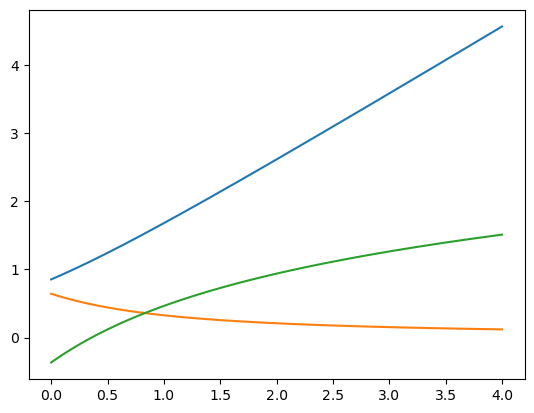

In [8]:
i = 3

plt.plot(a_grid, sol_c[i])
plt.plot(a_grid, sol_h[i])
plt.plot(a_grid, sol_V[i])

In [ ]:
N_sim = 100
T_sim = T

mu = -2.0       # mean of log(X)
sigma = 0.5    # std of log(X)

sim_a_init = np.clip(np.random.lognormal(mean=mu, sigma=sigma, size=100), 0, N_a_max)

sim_shape = (T_sim, N_sim)
sim_shape_a = (T_sim+1, N_sim)

a_sim = np.full(sim_shape_a, np.nan)
h_sim = np.full(sim_shape, np.nan)
c_sim = np.full(sim_shape, np.nan)

a_sim[0] = sim_a_init

for t in range(T_sim):
    for i in range(N_sim):
        a = a_sim[t, i]

        h = interp_1d(a_grid, sol_h[t], a)
        c = interp_1d(a_grid, sol_c[t], a)

        h_sim[t, i] = h
        c_sim[t, i] = c

        # update assets
        a_next = a + h + B(h, t) - c

        if t < T_sim:
            a_sim[t+1, i] = a_next


In [23]:
np.nanmean(np.where(h_sim > 0, 1.0, np.nan), axis=1)

hours_if_work = np.where(h_sim > 0, h_sim, np.nan).mean(axis=1)

In [1]:
plt.plot(share_working)
plt.plot(hours_if_work)

NameError: name 'plt' is not defined